# Import libs

In [3]:
import numpy as np
import pandas as pd

In [4]:
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice
from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from ucimlrepo import fetch_ucirepo 
plt.rcParams['figure.facecolor'] = (1,1,1,1)

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [6]:
import neural_lib as nl

In [7]:
# fetch dataset 
car_evaluation = fetch_ucirepo(id=19) 
  
# data (as pandas dataframes) 
feature = car_evaluation.data.features 
target = car_evaluation.data.targets 
cars= pd.concat([feature, target], axis=1)
cars

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


# Step 0. Binarize the data

In [8]:
# Perform one-hot encoding 
y = pd.get_dummies(target, columns=['class'], prefix=['class'])
X = pd.get_dummies(feature, columns=['buying','safety', 'persons', 'doors','maint','lug_boot'])

#convert the indices to str

y.index = X.index.astype(str)
X.index = X.index.astype(str)



X= X.rename_axis("Object")
y= y.rename_axis("Object")

# take just one class in the target varible(class_acc), to avoid multilabel-indicator
y_one_target = y['class_acc'].copy()
X

,buying_high,buying_low,buying_med,buying_vhigh,safety_high,safety_low,safety_med,persons_2,persons_4,persons_more,...,doors_3,doors_4,doors_5more,maint_high,maint_low,maint_med,maint_vhigh,lug_boot_big,lug_boot_med,lug_boot_small
Object,,,,,,,,,,,,,,,,,,,,,
0,False,False,False,True,False,True,False,True,False,False,...,False,False,False,False,False,False,True,False,False,True
1,False,False,False,True,False,False,True,True,False,False,...,False,False,False,False,False,False,True,False,False,True
2,False,False,False,True,True,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,True
3,False,False,False,True,False,True,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False
4,False,False,False,True,False,False,True,True,False,False,...,False,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,False,True,False,False,False,False,True,False,False,True,...,False,False,True,False,True,False,False,False,True,False
1724,False,True,False,False,True,False,False,False,False,True,...,False,False,True,False,True,False,False,False,True,False
1725,False,True,False,False,False,True,False,False,False,True,...,False,False,True,False,True,False,False,True,False,False


Split the data to train and test

In [9]:
# Split the dataset into training and testing sets (80% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_one_target, test_size=0.3, random_state=42)

## Step 1. Build Monotone Concept Lattice

Put binarized data in FormalContext and compute monotone ConceptLattice

In [10]:
K_train = FormalContext.from_pandas(X_train)

K_train

FormalContext (1209 objects, 21 attributes, 7254 connections)
    |buying_high|buying_low|buying_med|buying_vhigh|safety_high|...|maint_med|maint_vhigh|lug_boot_big|lug_boot_med|lug_boot_small|
1178|           |          |         X|            |          X|...|        X|           |           X|            |              |
585 |          X|          |          |            |           |...|         |           |            |            |             X|
1552|           |         X|          |            |           |...|        X|           |            |           X|              |
1169|           |          |         X|            |          X|...|        X|           |           X|            |              |
1033|           |          |         X|            |           |...|         |           |           X|            |              |
888 |           |          |         X|            |           |...|         |          X|           X|            |              |
1001|         

In [11]:
L = ConceptLattice.from_context(K_train, algo='Sofia', is_monotone=True)
len(L)

101

Compute F1 score for each formal concept  (assuming that an object is predicted True if it is in the extent of the concept)

In [12]:
from sklearn.metrics import f1_score

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train, y_preds)

Select indices of the best concepts from the lattice

In [13]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:4])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"
sum(L.measures['f1_score'])
len({g_i for c in L[best_concepts] for g_i in c.extent_i})

1209

Construct neural network based on concept lattice

In [14]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

Setup visuzalier for the architecture

In [15]:
#vis = LineVizNx(node_label_font_size=15, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n\n')
vis = LineVizNx(node_label_font_size=0, node_label_func=lambda el_i, P: '', flg_node_indices=False)

#### various techniques to select best features from the concept lattice:

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
chi2_features = SelectKBest(chi2)
x_kbest_features = chi2_features.fit_transform(X_train, y_train)
x_kbest_features_int = x_kbest_features.astype(int)
x_kbest_features.shape

(1209, 10)

In [17]:
# Get the selected feature indices
selected_feature_indices = chi2_features.get_support(indices=True)

# Get the names of the selected columns
selected_column_names = X_train.columns[selected_feature_indices]
for i in range(len(selected_column_names)):
    print(" feature with column_index {:} = {:}".
          format(selected_feature_indices[i], selected_column_names[i]))

 feature with column_index 3 = buying_vhigh
 feature with column_index 4 = safety_high
 feature with column_index 5 = safety_low
 feature with column_index 6 = safety_med
 feature with column_index 7 = persons_2
 feature with column_index 8 = persons_4
 feature with column_index 9 = persons_more
 feature with column_index 10 = doors_2
 feature with column_index 16 = maint_med
 feature with column_index 17 = maint_vhigh


Move the nodes in visualization to make it look pretty

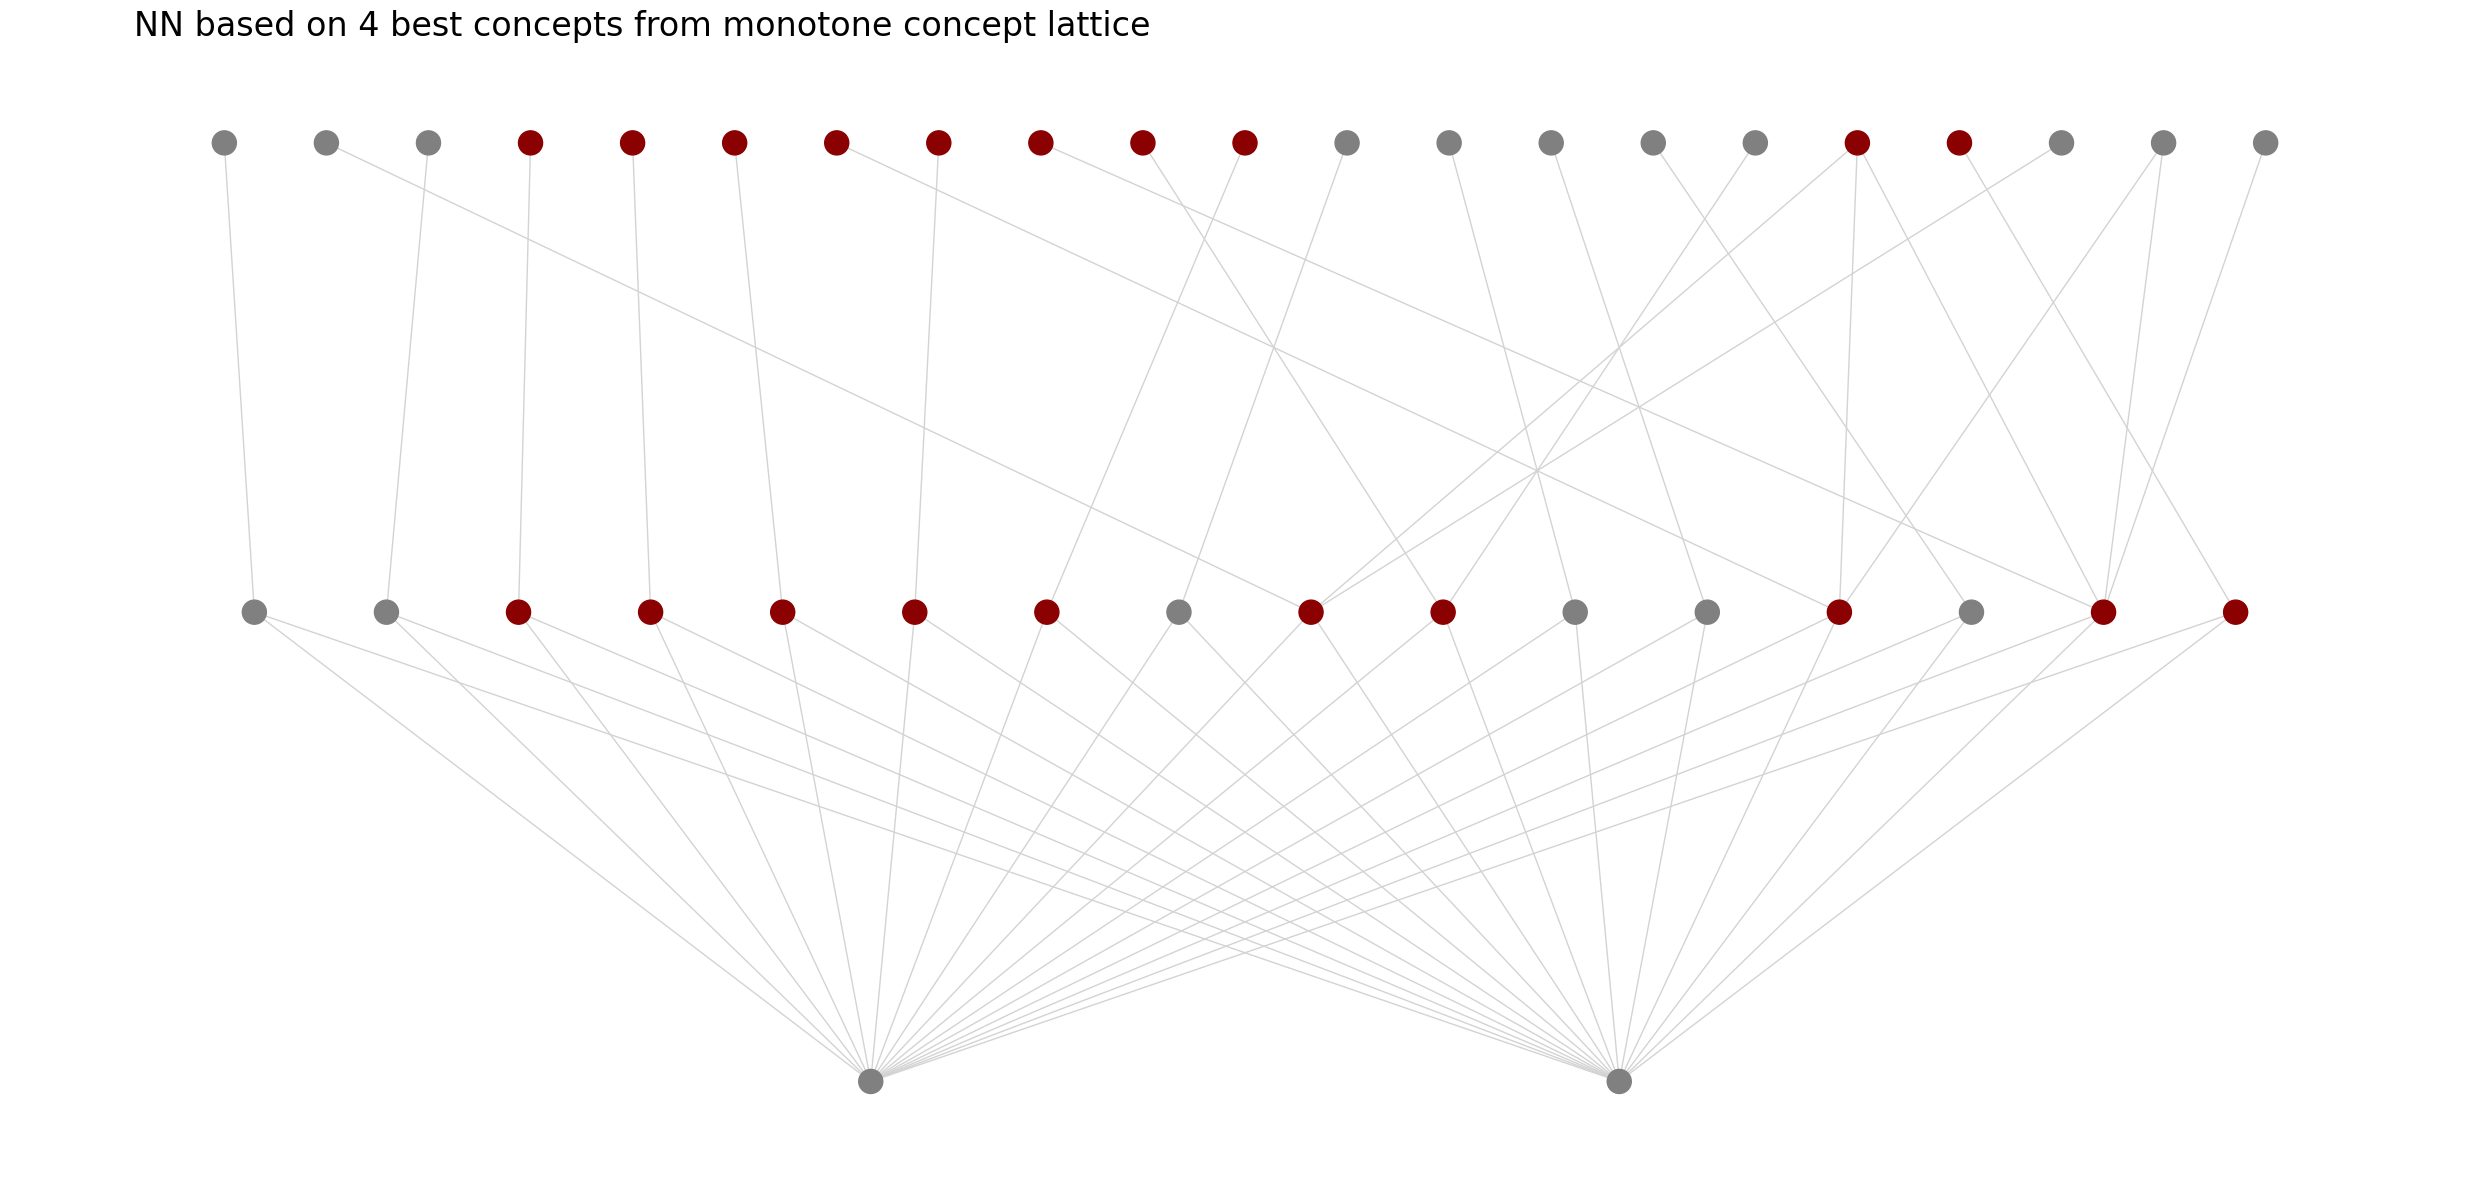

('buying_high',
 'buying_low',
 'buying_med',
 'buying_vhigh',
 'safety_high',
 'safety_low',
 'safety_med',
 'persons_2',
 'persons_4',
 'persons_more',
 'doors_2',
 'doors_3',
 'doors_4',
 'doors_5more',
 'maint_high',
 'maint_low',
 'maint_med',
 'maint_vhigh',
 'lug_boot_big',
 'lug_boot_med',
 'lug_boot_small')

In [18]:
# Create a new ConceptNetwork with feature attributes
cn_with_features = nl.ConceptNetwork(poset=cn.poset, attributes=selected_column_names)

# Visualize the ConceptNetwork with selected features
vis = LineVizNx(node_label_font_size=0, node_label_func=lambda el_i, P: '', flg_node_indices=False)

selected_column_names_class = set(selected_column_names)
traced = cn_with_features.trace_description(selected_column_names_class , include_targets=False)

fig, ax = plt.subplots(figsize=(25, 12))
vis.draw_poset(
    cn_with_features.poset, ax=ax,
    flg_node_indices=False,
    flg_node_labels=False,
    node_color=['darkred' if el_i in traced else 'gray' for el_i in range(len(cn_with_features.poset))]
)

plt.title(f'NN based on 4 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)
plt.subplots_adjust()
plt.tight_layout()
plt.show()
cn.attributes
#concerning the last level(target value), the left one is "False", and the right one is "True" 

In [19]:
cn.fit(X_train, y_train)

In [20]:
print('Class prediction', cn.predict(X_test).numpy())
print('Class prediction with probabilities', cn.predict_proba(X_test).detach().numpy())
print('True class', y_test.values)

Class prediction [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0

In [21]:
edge_weights = cn.edge_weights_from_network()

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sparselinear\sparselinear.py:301: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:607.)
  weight = torch.sparse.FloatTensor(self.indices, self.weights, (self.out_features, self.in_features))


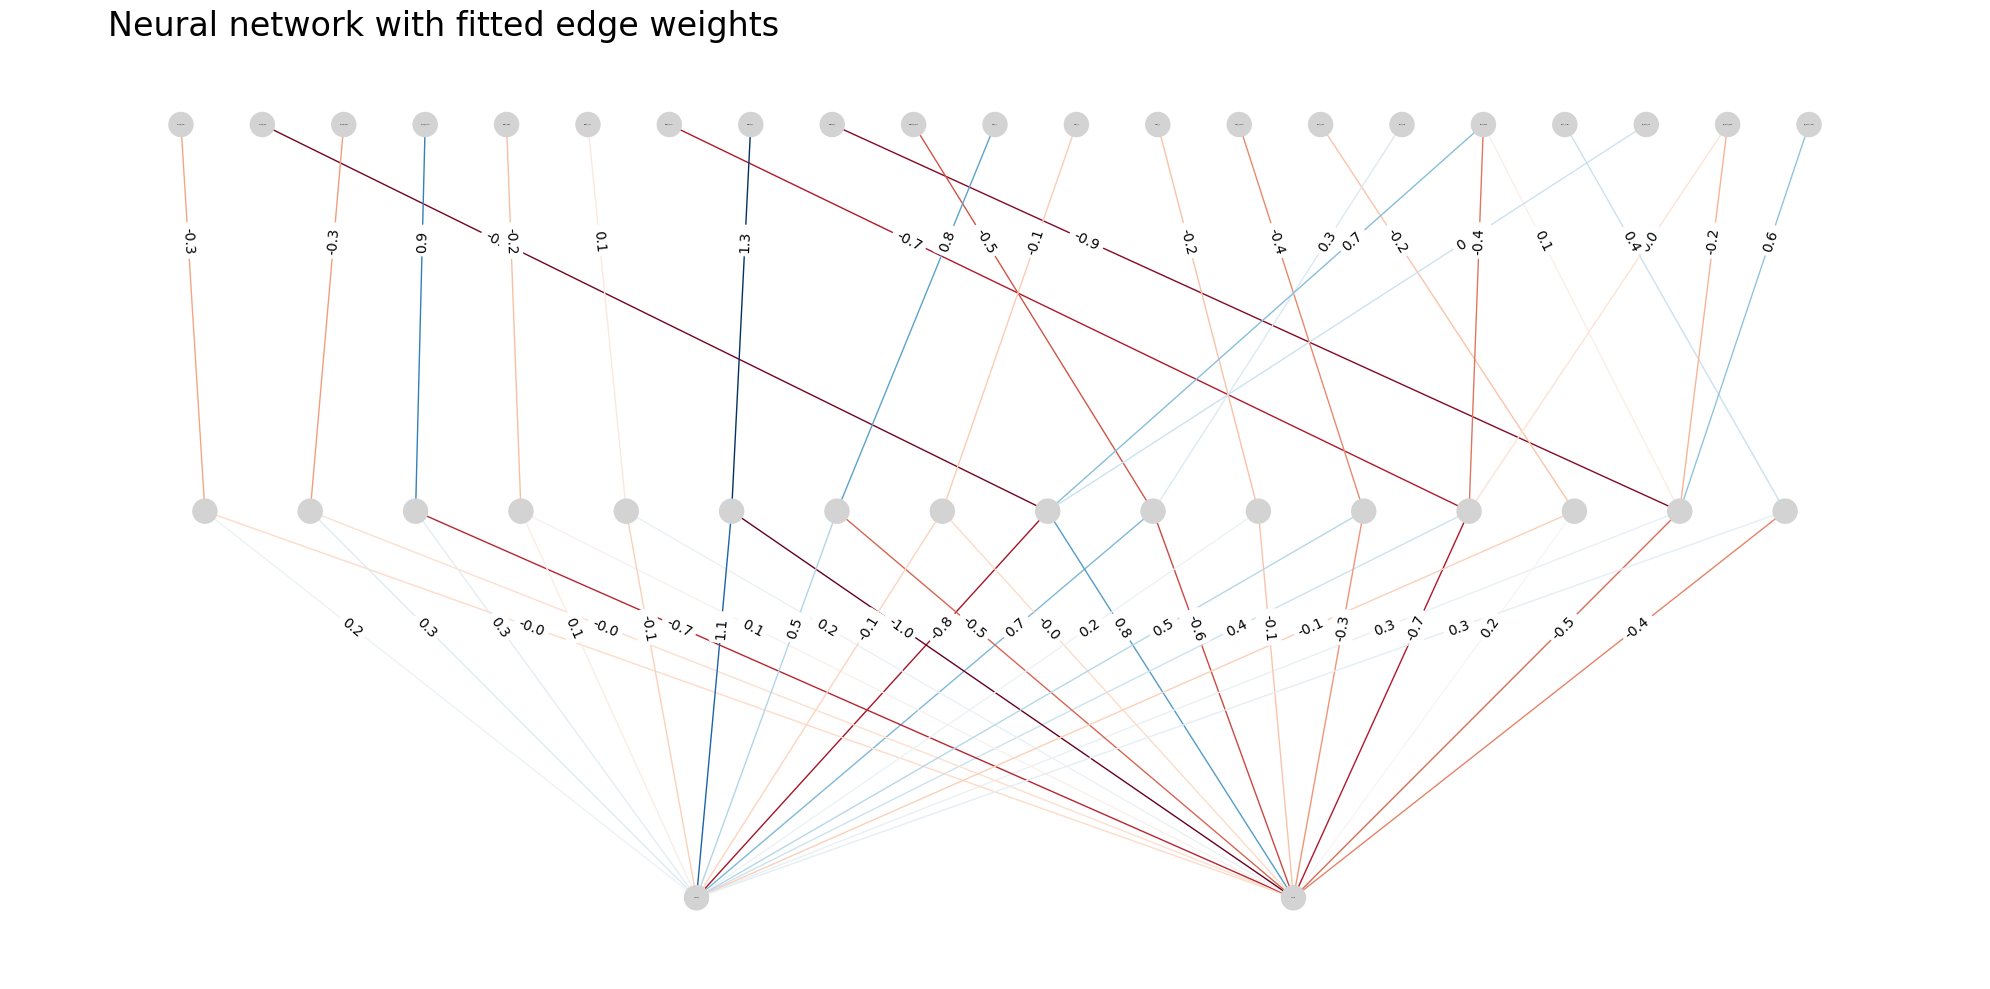

In [22]:
import networkx as nx

fig, ax = plt.subplots(figsize=(20,10))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()

In [23]:
final_y_test_str = y_test.astype(str)
# Initialize classifiers
classifiers = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'k-NN': KNeighborsClassifier(n_neighbors=3),
    'CatBoost': CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, random_state=42, verbose=0),
    'Logistic Regression': LogisticRegression(random_state=42, multi_class='ovr', max_iter=10000)
}

# Initialize empty dictionaries to store results
accuracies = {}
f1_scores = {}

# Perform cross-validation and parameter tuning for each classifier
for name, clf in classifiers.items():
    print(f"Training {name} Classifier...")
    
    if name == 'Decision Tree':
        # Define the parameter grid for Decision Tree
        param_grid = {
            'max_depth': [3, 4, 5, 6, 7],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    elif name == 'Random Forest':
        # Define the parameter grid for Random Forest
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 4, 5, 6, 7],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    elif name == 'k-NN':
        # Define the parameter grid for k-NN
        param_grid = {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        }
    else:
        param_grid = {}  # No parameter tuning for other classifiers
    
    # Create GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    
    # Train the classifier using GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best parameters and estimator from GridSearchCV
    best_params = grid_search.best_params_
    best_clf = grid_search.best_estimator_
    
    # Make predictions using the best classifier
    y_pred = best_clf.predict(X_test)
    y_pred_str = y_pred.astype(str)
    
    # Calculate accuracy and F1-score
    accuracy = accuracy_score(final_y_test_str, y_pred_str)
    f1 = f1_score(final_y_test_str, y_pred_str, average='weighted', zero_division=1)
    
    # Store results in dictionaries
    accuracies[name] = accuracy
    f1_scores[name] = f1
    
    # Display the results for the current classifier
    print(f"{name} Classifier:")
    print("Best Parameters:")
    print(best_params)
    print(f"Accuracy: {accuracy:.6f}")
    print(f"F1 Score: {f1:.6f}")
    print("Classification Report:")
    print(classification_report(final_y_test_str, y_pred_str))
    print("-" * 40)

# Display the overall performance of all classifiers
print("Overall Performance:")
for name in classifiers.keys():
    print(f"{name} - Accuracy: {accuracies[name]:.4f}, F1 Score: {f1_scores[name]:.4f}")


Training Decision Tree Classifier...
Decision Tree Classifier:
Best Parameters:
{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5}
Accuracy: 0.882466
F1 Score: 0.883317
Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.92      0.92       401
        True       0.73      0.76      0.75       118

    accuracy                           0.88       519
   macro avg       0.83      0.84      0.84       519
weighted avg       0.88      0.88      0.88       519

----------------------------------------
Training Random Forest Classifier...
Random Forest Classifier:
Best Parameters:
{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.903661
F1 Score: 0.898802
Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.97      0.94       401
        True       0.88      0.67      0.76       118

    accuracy                         

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [       nan 0.86848873        nan 0.88917733        nan 0.89827852]
  warnings.warn(


k-NN Classifier:
Best Parameters:
{'n_neighbors': 7, 'weights': 'distance'}
Accuracy: 0.901734
F1 Score: 0.898189
Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.96      0.94       401
        True       0.85      0.69      0.76       118

    accuracy                           0.90       519
   macro avg       0.88      0.83      0.85       519
weighted avg       0.90      0.90      0.90       519

----------------------------------------
Training CatBoost Classifier...


c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


CatBoost Classifier:
Best Parameters:
{}
Accuracy: 0.974952
F1 Score: 0.974594
Classification Report:
              precision    recall  f1-score   support

       False       0.97      1.00      0.98       401
        True       0.98      0.91      0.94       118

    accuracy                           0.97       519
   macro avg       0.98      0.95      0.96       519
weighted avg       0.98      0.97      0.97       519

----------------------------------------
Training Logistic Regression Classifier...
Logistic Regression Classifier:
Best Parameters:
{}
Accuracy: 0.797688
F1 Score: 0.794111
Classification Report:
              precision    recall  f1-score   support

       False       0.86      0.88      0.87       401
        True       0.56      0.51      0.53       118

    accuracy                           0.80       519
   macro avg       0.71      0.70      0.70       519
weighted avg       0.79      0.80      0.79       519

----------------------------------------
Overal

In [26]:
# Initialize the XGBoost classifier 
xgb_classifier = XGBClassifier(
    random_state=42,
    learning_rate=0.1,
    n_estimators=100,
    max_depth=3
)

# Train the classifier
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display results
print("Accuracy:", accuracy)
print(f"F1-score: {f1}")
print("Classification Report:")
print(classification_rep)

Accuracy: 0.9499036608863198
F1-score: 0.7941111087411452
Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.98      0.97       401
        True       0.91      0.86      0.89       118

    accuracy                           0.95       519
   macro avg       0.94      0.92      0.93       519
weighted avg       0.95      0.95      0.95       519



In [27]:
# Display the overall performance of all classifiers
print("Overall Performance:\n")
for name in classifiers.keys():
    print(f"{name} - Accuracy: {accuracies[name]:.4f}, F1 Score: {f1_scores[name]:.4f}")
    print("-" * 50)
    
print(f"XGBoost - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
print("-" * 50)

accuracy_FCA = accuracy_score( y_test.values, cn.predict(X_test).numpy())
f1_FCA = f1_score( y_test.values, cn.predict(X_test).numpy(), average='weighted', zero_division=1)
print(f"Neural_FCA - Accuracy: {accuracy_FCA:.4f}, F1 Score: {f1_FCA:.4f}")

Overall Performance:

Decision Tree - Accuracy: 0.8825, F1 Score: 0.8833
--------------------------------------------------
Random Forest - Accuracy: 0.9037, F1 Score: 0.8988
--------------------------------------------------
Naive Bayes - Accuracy: 0.7919, F1 Score: 0.8084
--------------------------------------------------
k-NN - Accuracy: 0.9017, F1 Score: 0.8982
--------------------------------------------------
CatBoost - Accuracy: 0.9750, F1 Score: 0.9746
--------------------------------------------------
Logistic Regression - Accuracy: 0.7977, F1 Score: 0.7941
--------------------------------------------------
XGBoost - Accuracy: 0.9499, F1 Score: 0.7941
--------------------------------------------------
Neural_FCA - Accuracy: 0.7726, F1 Score: 0.6871
